In [1]:
import numpy as np
from tqdm import tqdm
import time

In [2]:
def partitionData(X,y, num_points=10000, num_pivots=500):
    pivots_X = X[:num_pivots]
    pivots_y = y[:num_pivots]
    sample_X = X[num_pivots:num_points+num_pivots]
    sample_y = y[num_pivots:num_points+num_pivots]
    print("Partitioned data into ", num_points, " data points and ", num_pivots, " pivots")
    return sample_X, sample_y, pivots_X, pivots_y

In [62]:
def distanceMatrix(X,Y):
    A, _ = np.shape(X)
    B, _ = np.shape(Y)
    X2 = np.sum(X**2, axis=1).reshape(-1,1)
    Y2 = np.sum(Y**2, axis=1).reshape(-1,1)
    XY = X.dot(Y.T)
    dm = X2 - 2*XY + Y2.T
    return np.sqrt(dm)

def kNN(dm, k=5):
    dm_arr = np.asarray(dm)
    sorted_indices = np.argsort(dm_arr, axis=1)
    sorted_dm = dm_arr[sorted_indices]
    return sorted_dm[:,:k], indices[:,:k]

In [58]:
from scipy.spatial import cKDTree

def kNN_KDTree(X,pivots_X,k=5):
    print("Started kNN of data on pivots...")
    start = time.time()
    N,_ = X.shape
    sorted_dm = np.zeros((N,k))
    sorted_indices = np.zeros((N,k))
    kdtree = cKDTree(pivots_X, leafsize=40)
    #kdtree = BallTree(pivots_X, leaf_size=40)
    sorted_dm, sorted_indices = kdtree.query(X, k=k, p=2)
    #sorted_dm, sorted_indices = kdtree.query(X, k=k)
    #for n in tqdm(range(N)):
    #    sorted_dm[n], sorted_indices[n] = kdtree.query([X[n]], k=k, p=2)
    end = time.time()
    print("Finished kNN of data on pivots in ", (end - start), " secs")
    return sorted_dm, sorted_indices.astype(int)

In [73]:
def computeSpringStrengths(pivots_X, sorted_dm, sorted_indices, use_pivots_dm=False):
    print("Started spring strength computation between pivots...")
    start = time.time()
    pivots_dm = None
    if use_pivots_dm:
        pivots_dm = distanceMatrix(pivots_X, pivots_X)
    N,k = sorted_dm.shape
    spring_strengths = {}
    for n in tqdm(range(N)):
        for i in range(k):
            for j in range(i+1,k):
                di = sorted_dm[n,i]
                dj = sorted_dm[n,j]
                pi = int(sorted_indices[n,i])
                pj = int(sorted_indices[n,j])
                if pi > pj:
                    pi,pj = pj,pi
                    di,dj = dj,di
                edge = (pi,pj)
                if edge in spring_strengths:
                    spring_strengths[edge]+=(1/(di+dj+1e-12))
                else:
                    if pivots_dm is None:
                        D = np.sqrt(np.sum((pivots_X[pi]-pivots_X[pj])**2) + 1e-12)
                    else:
                        D = pivots_dm[pi,pj]
                    spring_strengths[edge]=((1/D) + (1/(di+dj+1e-12)))
    end = time.time()
    print("Finished spring strength computation in ", (end - start), " secs")
    return spring_strengths

In [80]:
from scipy import sparse
def getLiLMatrix(num_pivots, graph_dict):
    I, J, V = [], [], []
    for src_dst, weight in graph_dict.items():
        I.append(src_dst[0])
        J.append(src_dst[1])
        V.append(weight)
    lil_matrix = sparse.lil_matrix((num_pivots, num_pivots))
    lil_matrix[I,J] = V
    lil_matrix[J,I] = V
    return lil_matrix

def getKnnFromGraph(num_pivots, lil_matrix, k=10):
    print("Started kNN graph computation from lil_matrix...")
    start = time.time()
    spring_graph = {}
    graph_nodes = set()
    for p in tqdm(range(num_pivots)):
        neighbors = np.asarray(lil_matrix.rows[p])
        neighbor_dist = np.asarray(lil_matrix.data[p])
        num_neighbors = len(neighbors)
        
        nn_indices = None
        if num_neighbors > k:
            nn_indices = np.argpartition(neighbor_dist, kth=num_neighbors-k)[-k:].astype(int)
        elif num_neighbors > 0:
            nn_indices = range(num_neighbors)
            
        if nn_indices is None:
            continue
        else:
            graph_nodes.add(p)
            nn_dist = neighbor_dist[[nn_indices]]
            nn_pivots = neighbors[[nn_indices]]
            for j in range(len(nn_indices)):
                pi = p
                pj = nn_pivots[j]
                dij = nn_dist[j]
                if pi > pj:
                    pi,pj = pj,pi
                edge = (pi,pj)
                if not(edge in spring_graph):
                    spring_graph[edge]=dij
    end = time.time()
    print("Finished kNN graph of pivots in ", (end - start), " secs")
    return spring_graph, list(graph_nodes)

In [85]:
import networkx as nx
colors = ["blue", "red", "green", "yellow", "brown", "pink", "orange", "gray", "cyan", "greenyellow"]

def genPivotsNetGraph(spring_graph_dict, graph_nodes, pivots_y):
    print("Preparing networkx graph...")
    start = time.time()
    G=nx.Graph()
    for i in graph_nodes:
        G.add_node(i, {'color':colors[int(pivots_y[i])], 'cluster':int(pivots_y[i])})
    
    weighted_edges = []
    for src_dst, strength in spring_graph_dict.items():
        weighted_edges.append((src_dst[0],src_dst[1],strength))
        
    G.add_weighted_edges_from(weighted_edges)
    end = time.time()
    print("Finished preparing networkx graph in ", (end - start), " secs")
    return G

In [8]:
import matplotlib.pyplot as plt

def vizSpringGraph(G, y, dim=2, iterations=100):
    print("Preparing networkx visualization...")
    start = time.time()
    print("Computing spring layout positions...")
    pos = nx.spring_layout(G, dim=dim, iterations=iterations)
    end = time.time()
    print("Finished computing spring layout positions in ", (end - start), " secs")
    %matplotlib notebook
    plt.ion()
    for n in G.nodes():
        nx.draw_networkx_nodes(G,pos, with_labels=False, nodelist=[n], node_size=5,
                               node_color=colors[int(y[n])])
    plt.axis('off')
    plt.show()
    end = time.time()
    print("Finished networkx visualization in ", (end - start), " secs")

In [9]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA

mnist = fetch_mldata("MNIST original")
pca = PCA(n_components=100)
MX = pca.fit_transform(mnist.data / 255.0)
#MX = mnist.data / 255.0
My = mnist.target
print('Explained total variation: ,', format(sum(pca.explained_variance_ratio_)))
print(MX.shape)
rndperm = np.random.permutation(MX.shape[0])
MX = MX[rndperm]
My = My[rndperm]

Explained total variation: , 0.914540603787462
(70000, 100)


In [49]:
num_points = 20000
num_pivots = 5000
sample_X, sample_y, pivots_X, pivots_y = partitionData(MX[rndperm], My[rndperm],
                                              num_points=num_points,
                                              num_pivots=num_pivots)
print(sample_X.shape, sample_y.shape, pivots_X.shape, pivots_y.shape)

Partitioned data into  20000  data points and  5000  pivots
(20000, 100) (20000,) (5000, 100) (5000,)


In [59]:
sorted_dm, sorted_indices = kNN_KDTree(sample_X, pivots_X, k=10)
print(sorted_dm.shape)
print(sorted_indices.shape)

Started kNN of data on pivots...
Finished kNN of data on pivots in  7.873716115951538  secs
(20000, 10)
(20000, 10)


In [60]:
print(sorted_dm[0])
print(sorted_indices[0])
print(pivots_y[sorted_indices[0]])
print(sample_y[0])

[ 3.94590984  4.3805622   4.55415305  4.5626399   4.70940856  4.73261309
  4.75968519  4.79264929  4.81815102  4.8439623 ]
[2689 3877 3721  152 2525 4270 1027 1761 2949 4087]
[ 7.  7.  7.  7.  7.  7.  7.  7.  7.  1.]
7.0


In [75]:
spring_strengths = computeSpringStrengths(pivots_X, sorted_dm, sorted_indices, True)

Started spring strength computation between pivots...


/Users/chippada.bhargav/Desktop/bhargavchippada/randomfun/.env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
100%|██████████| 20000/20000 [00:02<00:00, 8624.52it/s]

Finished spring strength computation in  3.1838090419769287  secs


In [76]:
print(len(spring_strengths))
lil_matrix = getLiLMatrix(num_pivots, spring_strengths)
print(lil_matrix.count_nonzero())

261357
522714


In [83]:
spring_graph,graph_nodes = getKnnFromGraph(num_pivots, lil_matrix, k=10)

 42%|████▏     | 2124/5000 [00:00<00:00, 21238.75it/s]

Started kNN graph computation from lil_matrix...


100%|██████████| 5000/5000 [00:00<00:00, 22594.80it/s]

Finished kNN graph of pivots in  0.22349214553833008  secs


In [84]:
print(len(spring_graph))
print(len(graph_nodes))

37106
4998


In [87]:
PG = genPivotsNetGraph(spring_graph, graph_nodes, pivots_y)

Preparing networkx graph...
Finished preparing networkx graph in  0.12520194053649902  secs


In [88]:
print(PG.number_of_nodes())
print(PG.number_of_edges())

4998
37106


Preparing networkx visualization...
Computing spring layout positions...
Finished computing spring layout positions in  169.53089904785156  secs


<IPython.core.display.Javascript object>


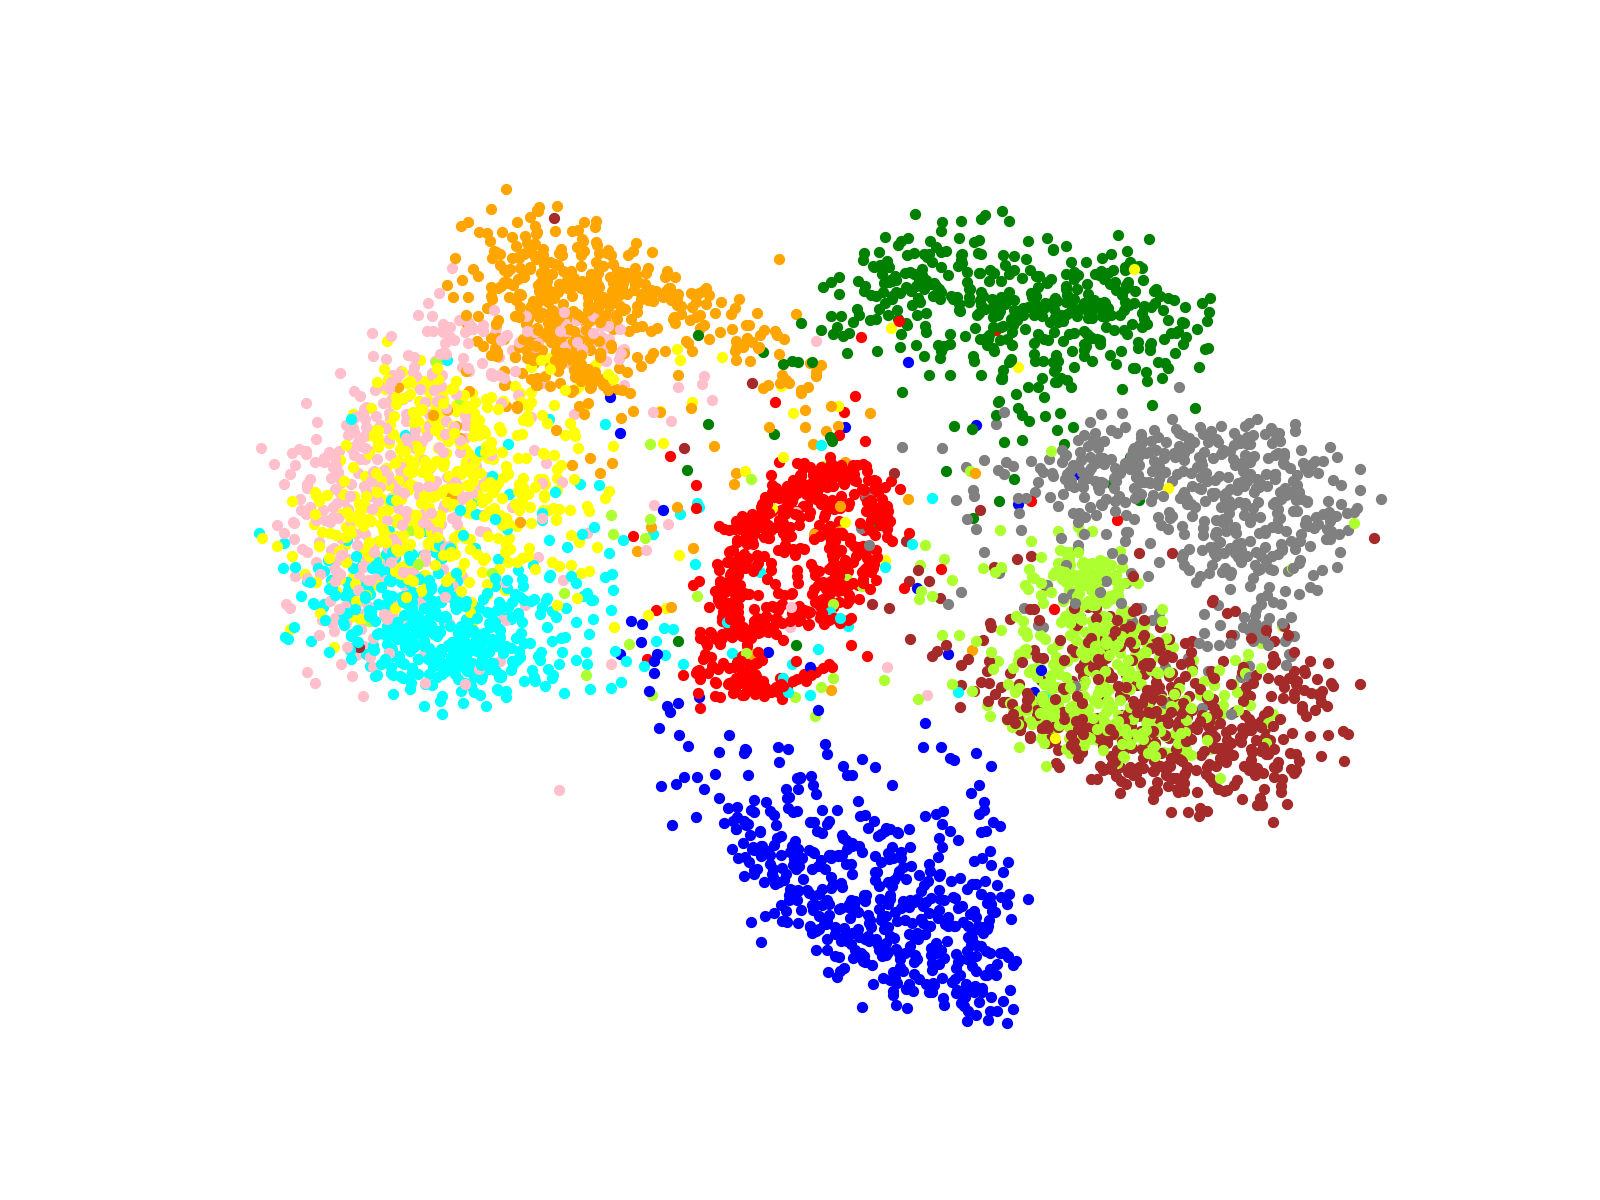

Finished networkx visualization in  189.33034706115723  secs


In [89]:
vizSpringGraph(PG, pivots_y, dim=2, iterations=100)